# Overlap-add processing in the time domain

In which we explore the boundaries of invertibility of overlap-add (OLA) in the time domain. In [this blog post](https://gauss256.github.io/blog/cola.html) we show that a time-domain signal $t$ can be recovered from its windowed frames $\{x_t\}$ by the formula

$$x[n]=\frac{\sum_{t=-\infty}^{\infty}x_{t}[n]w^{a}[n-tH]}{\sum_{t=-\infty}^{\infty}w^{a+1}[n-tH]}\tag{1}$$

where $a$ is a constant that is usually chosen as $a=1$.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

## Prepare the frames

In [2]:
# Parameters
L = 2 * 1024  # signal length
N = 256  # frame length
H = 128  # hop size
a = 0  # exponent of window function
window = "hann"
boundary = True  # needs to be true to recover x[0], x[-1]
padding = True  # pad to avoid dropping a short frame at the end

In [3]:
# Create random data
x = np.random.uniform(-1, 1, L)

In [4]:
# Add padding
if padding:
    nshort = (L - N) % H
    if nshort != 0:
        extend = np.zeros(H - nshort, dtype=x.dtype)
        x = np.concatenate((x, extend))
    print(f"Padding applied")

Padding applied


In [5]:
# Add boundary
if boundary:
    nbdry = N // 2
    bdry = np.zeros(nbdry, dtype=x.dtype)
    x = np.concatenate((bdry, x, bdry))
    print(f"Boundary applied")

Boundary applied


In [6]:
# Create window
w = signal.get_window(window, N + 2, False)[1:-1]

In [7]:
# Create windowed frames
nframes = 1 + (len(x) - N) // H
frames = np.array([x[t * H:t * H + N] * w for t in range(nframes)])

## Invert the frames

In [8]:
# Invert using overlap-add
y = np.zeros_like(x)  # unnormalized reconstructed frames
d = np.zeros_like(x)  # normalization factors (denominator)
for t, frame in enumerate(frames):
    y[t * H:t * H + N] += frame * w**a
    d[t * H:t * H + N] += w**(a+1)

In [9]:
# Compensate for boundary and padding
if boundary:
    x = x[nbdry:-nbdry]
    y = y[nbdry:-nbdry]
    d = d[nbdry:-nbdry]
if padding:
    x = x[:L]
    y = y[:L]
    d = d[:L]

In [10]:
# Normalize the inverted frames
tol = 1e-7
dnz = np.where(np.abs(d) > 1e-7)  # denominator not zero
z = y.copy()
z[dnz] /= d[dnz]  # y is not normalized, z is normalized

## Check whether inversion was successful

In [11]:
# Check for successful inversion
# We'll allow for the possibility that y = c * x for some constant c
c = np.sum(x * y) / np.sum(x * x)  # optimal least-squares estimate for c
print(f"Is unnormalized close? {np.allclose(y, c * x)}")
print(f"Is normalized close?   {np.allclose(z, x)}")

Is unnormalized close? False
Is normalized close?   True


## Plot the normalization values

As the plot below shows, the normalization values vary a lot with $n$.

d min: 1.00
d max: 1.01


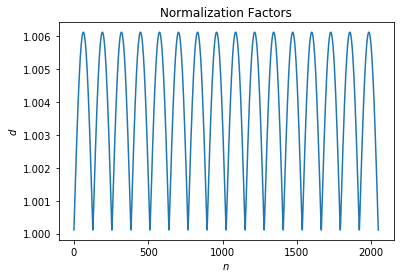

In [12]:
print(f"d min: {np.min(d):0.2f}")
print(f"d max: {np.max(d):0.2f}")
plt.plot(d)
plt.title("Normalization Factors")
plt.xlabel("$n$")
plt.ylabel("$d$")
plt.show()

## Summary and conclusion

For most choices of the window $w$, overlap-add will _not_ recover $x$ exactly unless the proper normalization factors are applied and some care is taken to handle values at the boundaries. But when equation (1) is applied along with judicious padding, we can recover $x$ exactly for a wide variety of window and overlap configurations.